# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.9.1'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Detailed citaition list:
Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/

### The number of cases (JHU style)
The main dataset is that of the number of cases. This includes "Confirmed", "Infected", "Recovered" and "Fatal". "Infected" was calculated as "Confirmed - Recovered - Fatal".

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [6]:
# Citation of COVID-19 Data Hub: this was shown when `DataLoader.jhu(verbose=True)
# print(data_loader.covid19dh_citation)

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
278830,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278831,2020-10-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278832,2020-10-22,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278833,2020-10-23,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278834,2020-10-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
278830,2020-10-20,Colombia,Vichada,14,0,0,14
278831,2020-10-21,Colombia,Vichada,14,0,0,14
278832,2020-10-22,Colombia,Vichada,14,0,0,14
278833,2020-10-23,Colombia,Vichada,14,0,0,14
278834,2020-10-24,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
215,2020-10-20,29185,1938,437,26810
216,2020-10-21,29335,1858,439,27038
217,2020-10-22,29520,1851,442,27227
218,2020-10-23,29706,1806,445,27455
219,2020-10-24,29909,2009,445,27455


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-10-20,40362354,11814489,1115871,27431994,0.013823,0.339822,0.039088
2020-10-21,40795574,12032381,1122373,27640820,0.013756,0.338772,0.039021
2020-10-22,41243136,12266116,1127979,27849041,0.013675,0.337620,0.038927
2020-10-23,41699945,12530384,1134638,28034923,0.013605,0.336151,0.038898
2020-10-24,41700972,12618015,1134647,27948310,0.013605,0.335104,0.039014


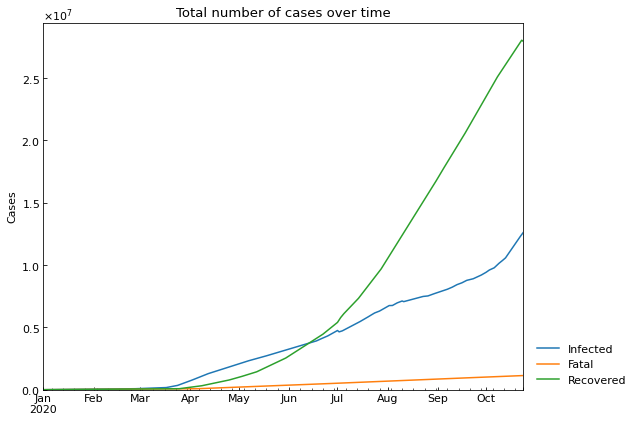

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan
If we have dataset for each country, we can use it optionally.

In [12]:
# Registered data in jhu_data
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
254,2020-10-20,93904,5752,1679,86473
255,2020-10-21,94523,5771,1686,87066
256,2020-10-22,95140,5801,1697,87642
257,2020-10-23,95887,5958,1709,88220
258,2020-10-24,96619,94906,1713,87053


In [13]:
# Download the dataset in Japan and show the citation
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [14]:
# Replace the dataset for Japan
jhu_data.replace(japan_data)
# Show the new records in Japan
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
252,2020-10-20,93480,5291,1676,86513
253,2020-10-21,93933,5147,1679,87107
254,2020-10-22,94524,5173,1685,87666
255,2020-10-23,95138,5199,1694,88245
256,2020-10-24,95835,5342,1706,88787


### Population in each country
Population values are necessary to calculate the number of susceptible people. Susceptible is a variable of SIR-derived models.

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
278830,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278831,2020-10-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278832,2020-10-22,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278833,2020-10-23,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278834,2020-10-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
236067,COL,Colombia,Vichada,2020-10-20,107808
236068,COL,Colombia,Vichada,2020-10-21,107808
236069,COL,Colombia,Vichada,2020-10-22,107808
236070,COL,Colombia,Vichada,2020-10-23,107808
236071,COL,Colombia,Vichada,2020-10-24,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)
This will be used in [Usage (details: policy measures)](https://lisphilar.github.io/covid19-sir/usage_policy.html).

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
278830,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278831,2020-10-21,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278832,2020-10-22,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278833,2020-10-23,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
278834,2020-10-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
278830,2020-10-20,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
278831,2020-10-21,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
278832,2020-10-22,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
278833,2020-10-23,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
278834,2020-10-24,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
293,2020-10-20,0,1,1,0,0,1,1,3,2,2,1,35.19
294,2020-10-21,0,1,1,0,0,1,1,3,2,2,1,35.19
295,2020-10-22,0,1,1,0,0,1,1,3,2,2,1,35.19
296,2020-10-23,0,1,1,0,0,1,1,3,2,2,1,35.19
297,2020-10-24,0,1,1,0,0,1,1,3,2,2,1,35.19


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
293,2020-10-20,0,1,1,0,0,1,1,3,2,2,1,35.19
294,2020-10-21,0,1,1,0,0,1,1,3,2,2,1,35.19
295,2020-10-22,0,1,1,0,0,1,1,3,2,2,1,35.19
296,2020-10-23,0,1,1,0,0,1,1,3,2,2,1,35.19
297,2020-10-24,0,1,1,0,0,1,1,3,2,2,1,35.19


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

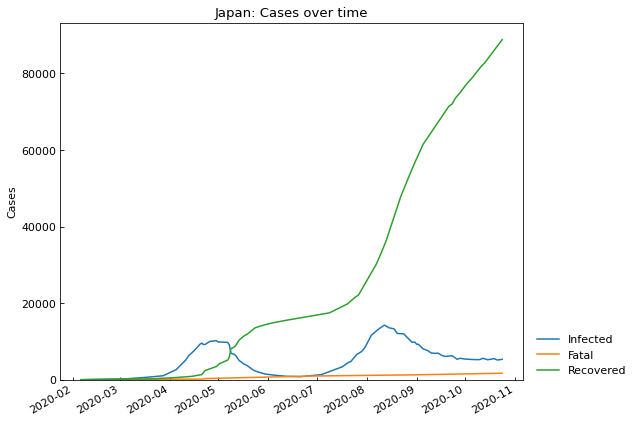

,Date,Confirmed,Infected,Fatal,Recovered
252,2020-10-20,93480,5291,1676,86513
253,2020-10-21,93933,5147,1679,87107
254,2020-10-22,94524,5173,1685,87666
255,2020-10-23,95138,5199,1694,88245
256,2020-10-24,95835,5342,1706,88787


In [26]:
record_df = snl.records()
record_df.tail()

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

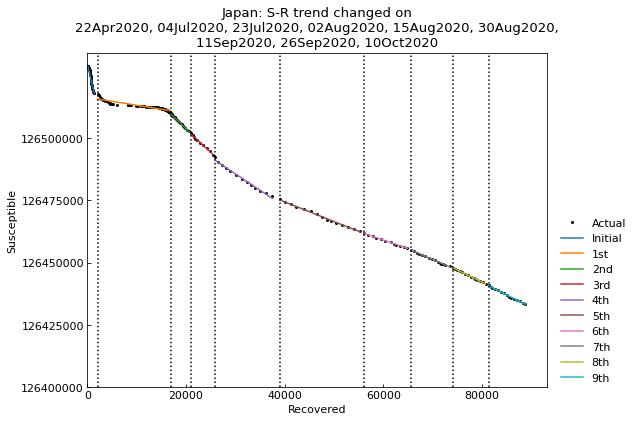

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,03Jul2020,126529100
2nd,Past,04Jul2020,22Jul2020,126529100
3rd,Past,23Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,29Aug2020,126529100
6th,Past,30Aug2020,10Sep2020,126529100
7th,Past,11Sep2020,25Sep2020,126529100
8th,Past,26Sep2020,09Oct2020,126529100
9th,Past,10Oct2020,24Oct2020,126529100


In [27]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [28]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (10Oct2020 - 24Oct2020): finished 1721 trials in 1 min  0 sec


	 1st phase (22Apr2020 - 03Jul2020): finished 1727 trials in 1 min  0 sec

	 0th phase (06Feb2020 - 21Apr2020): finished 1745 trials in 1 min  0 sec

	 2nd phase (04Jul2020 - 22Jul2020): finished 1780 trials in 1 min  0 sec

	 3rd phase (23Jul2020 - 01Aug2020): finished 1782 trials in 1 min  0 sec

	 6th phase (30Aug2020 - 10Sep2020): finished  256 trials in 0 min  5 sec

	 7th phase (11Sep2020 - 25Sep2020): finished  253 trials in 0 min  5 sec

	 5th phase (15Aug2020 - 29Aug2020): finished  475 trials in 0 min 10 sec

	 8th phase (26Sep2020 - 09Oct2020): finished  491 trials in 0 min 10 sec

	 4th phase (02Aug2020 - 14Aug2020): finished 2091 trials in 1 min  0 sec

Completed optimization. Total: 3 min  2 sec


In [29]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],alpha1 [-],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,5.20,0.018968,0.000063,0.051253,0.009609,720,7886,0.019,9,52,0.944454,1745,1 min 0 sec
1st,Past,22Apr2020,03Jul2020,126529100,SIR-F,0.37,0.111909,0.000099,0.014053,0.033633,720,5049,0.112,35,14,0.817521,1727,1 min 0 sec
2nd,Past,04Jul2020,22Jul2020,126529100,SIR-F,2.05,0.000541,0.000094,0.071465,0.034698,720,5292,0.001,6,14,0.038879,1780,1 min 0 sec
3rd,Past,23Jul2020,01Aug2020,126529100,SIR-F,1.97,0.000589,0.000114,0.066524,0.033642,720,4397,0.001,7,14,0.033520,1782,1 min 0 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.56,0.000172,0.000176,0.051761,0.033087,720,2840,0.000,9,15,0.061574,2091,1 min 0 sec
5th,Past,15Aug2020,29Aug2020,126529100,SIR-F,0.76,0.000468,0.000552,0.039566,0.051693,720,906,0.000,12,9,0.050953,475,0 min 10 sec
6th,Past,30Aug2020,10Sep2020,126529100,SIR-F,0.71,0.000350,0.000711,0.032127,0.044790,720,702,0.000,15,11,0.018508,256,0 min 5 sec
7th,Past,11Sep2020,25Sep2020,126529100,SIR-F,0.78,0.016526,0.000059,0.038955,0.049122,720,8453,0.017,12,10,0.072541,253,0 min 5 sec
8th,Past,26Sep2020,09Oct2020,126529100,SIR-F,1.05,0.000647,0.000593,0.048559,0.045813,720,842,0.001,10,10,0.031941,491,0 min 10 sec
9th,Past,10Oct2020,24Oct2020,126529100,SIR-F,1.02,0.000605,0.000471,0.051649,0.050354,720,1060,0.001,9,9,0.024116,1721,1 min 0 sec


### Accuracy of estimation

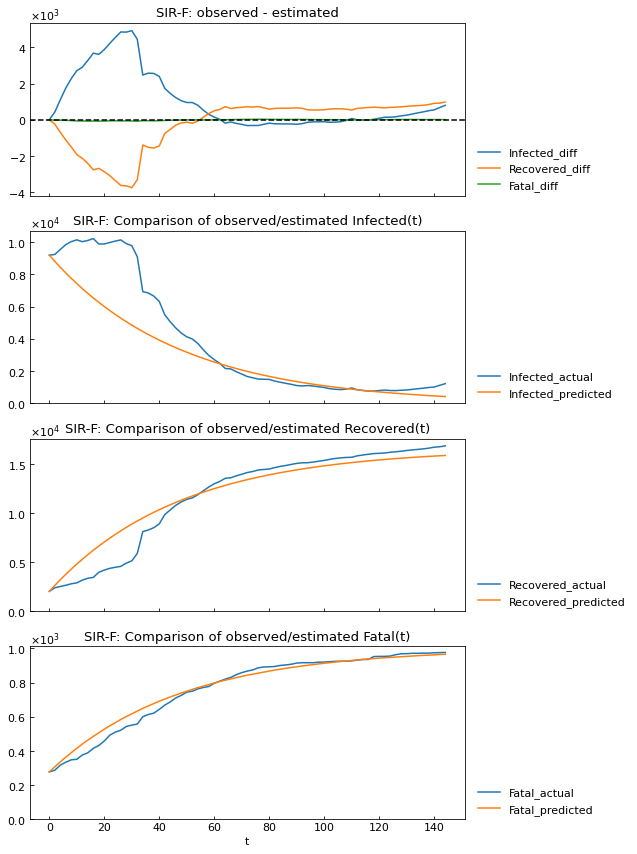

In [30]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
snl.get("Rt", phase="4th")

1.56

### Show parameter history

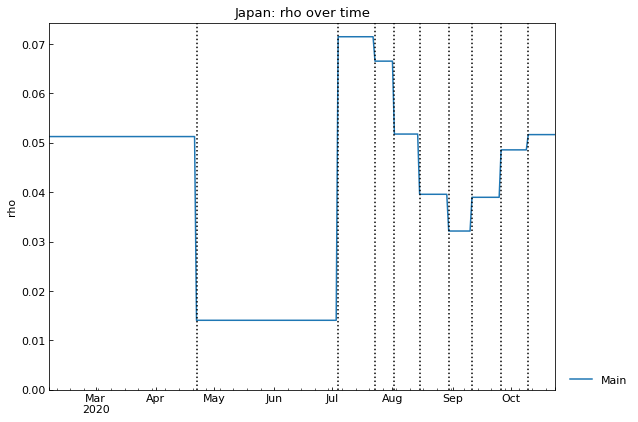

In [32]:
_ = snl.history(target="rho")

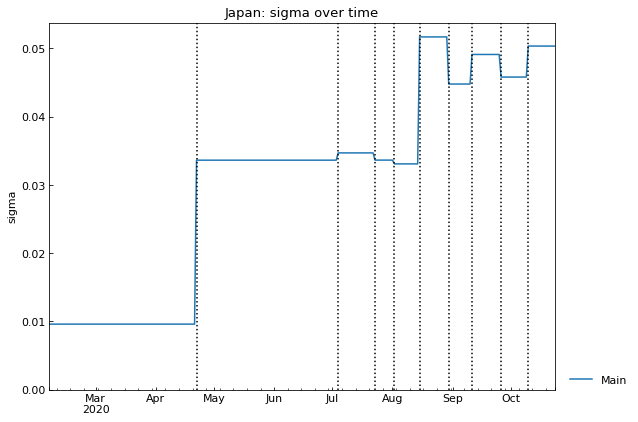

In [33]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

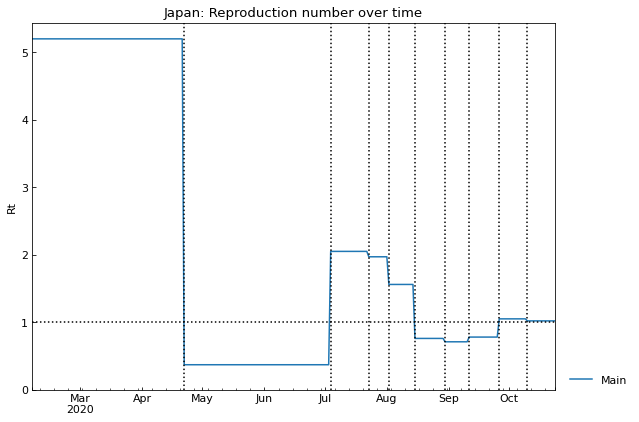

In [34]:
_ = snl.history(target="Rt")

### Simulate the number of cases

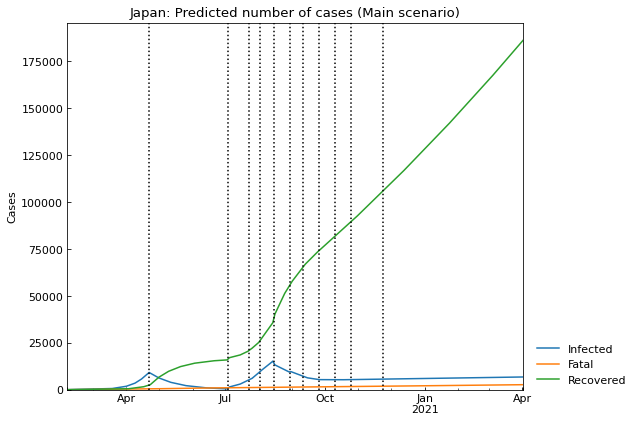

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,193041,2645,6745,183651
418,2021-03-30,193736,2652,6754,184330
419,2021-03-31,194434,2659,6764,185011
420,2021-04-01,195133,2666,6774,185693
421,2021-04-02,195831,2672,6783,186376


In [35]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [36]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.05035430840080921

In [37]:
sigma_new = sigma_current * 2
sigma_new

0.10070861680161843

In [38]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  5.20   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.37   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.05   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  1.97   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.56   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.76   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.71   
         7th      Past  11Sep2020  25Sep2020   126529100  SIR-F  0.78   
         8th      Past  26Sep2020  09Oct2020   126529100  SIR-F  1.05   
         9th      Past  10Oct2020  24Oct2020   126529100  SIR-F  1.02   
         10th   Future  25Oct2020  23Nov2020   126529100  SIR-F  1.02   
         11th   Future  24Nov2020  01Apr2021   126529100  SIR-F  1.02   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  5.20   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.37   
         2nd      Past  04Jul2020  22Jul2020   126529100  SIR-F  2.05   
         3rd      Past  23Jul2020  01Aug2020   126529100  SIR-F  1.97   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.56   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.76   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.71   
         7th      Past  11Sep2020  25Sep2020   126529100  SIR-F  0.78   
         8th      Past  26Sep2020  09Oct2020   126529100  SIR-F  1.05   
         9th      Past  10Oct2020  24Oct2020   126529100  SIR-F  1.02   
         10th   Future  25Oct2020  23Nov2020   126529100  SIR-F  1.02   
         11th   Future  24Nov2020  01Apr2021   126529100  SIR-F  0.51   

                   theta     kappa       rho     sigma  tau  1/alpha2 [day]  \
Scenario Phase                                                                
Main     0th    0.018968  0.000063  0.051253  0.009609  720            7886   
         1st    0.111909  0.000099  0.014053  0.033633  720            5049   
         2nd    0.000541  0.000094  0.071465  0.034698  720            5292   
         3rd    0.000589  0.000114  0.066524  0.033642  720            4397   
         4th    0.000172  0.000176  0.051761  0.033087  720            2840   
         5th    0.000468  0.000552  0.039566  0.051693  720             906   
         6th    0.000350  0.000711  0.032127  0.044790  720             702   
         7th    0.016526  0.000059  0.038955  0.049122  720            8453   
         8th    0.000647  0.000593  0.048559  0.045813  720             842   
         9th    0.000605  0.000471  0.051649  0.050354  720            1060   
         10th   0.000605  0.000471  0.051649  0.050354  720            1060   
         11th   0.000605  0.000471  0.051649  0.050354  720            1060   
Medicine 0th    0.018968  0.000063  0.051253  0.009609  720            7886   
         1st    0.111909  0.000099  0.014053  0.033633  720            5049   
         2nd    0.000541  0.000094  0.071465  0.034698  720            5292   
         3rd    0.000589  0.000114  0.066524  0.033642  720            4397   
         4th    0.000172  0.000176  0.051761  0.033087  720            2840   
         5th    0.000468  0.000552  0.039566  0.051693  720             906   
         6th    0.000350  0.000711  0.032127  0.044790  720             702   
         7th    0.016526  0.000059  0.038955  0.049122  720            8453   
         8th    0.000647  0.000593  0.048559  0.045813  720             842   
         9th    0.000605  0.000471  0.051649  0.050354  720            1060   
         10th   0.000605  0.000471  0.051649  0.050354  720            1060   
         11th   0.000605  0.000471  0.051649  0.100709  720            1060   

                alpha1 [-]  1/beta [day]  1/gamma [day]      RMS

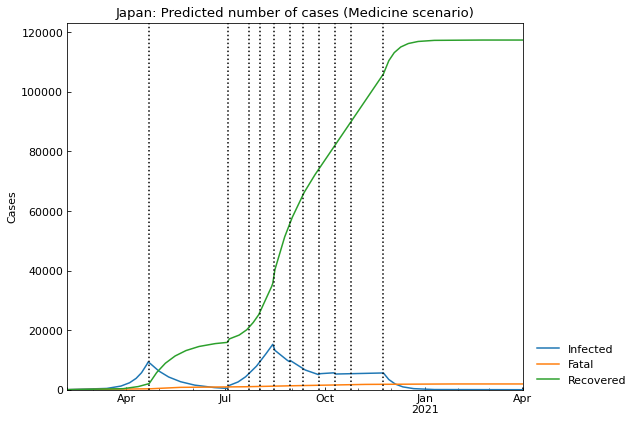

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,119322,1927,0,117395
418,2021-03-30,119322,1927,0,117395
419,2021-03-31,119322,1927,0,117395
420,2021-04-01,119322,1927,0,117395
421,2021-04-02,119322,1927,0,117395


In [39]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [40]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,11th_Rt
Main,15223,14Aug2020,195831,6783,2672,1.02
Medicine,15223,14Aug2020,119322,0,1927,0.51


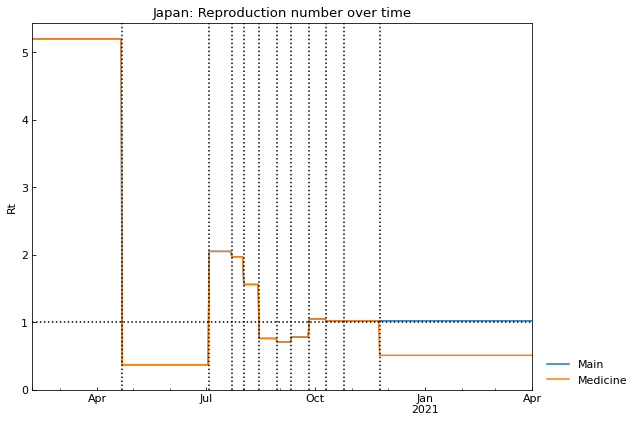

In [41]:
_ = snl.history(target="Rt")

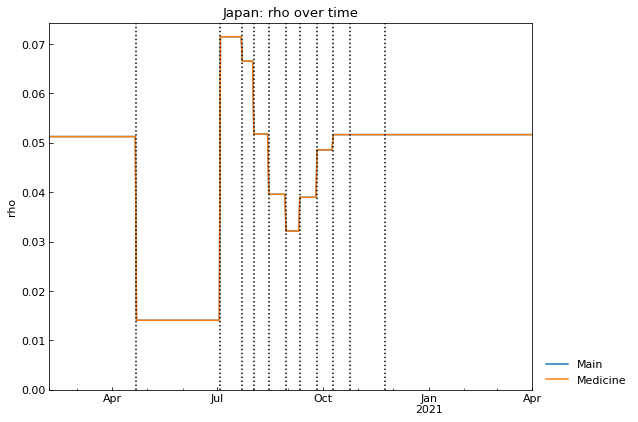

In [42]:
_ = snl.history(target="rho")

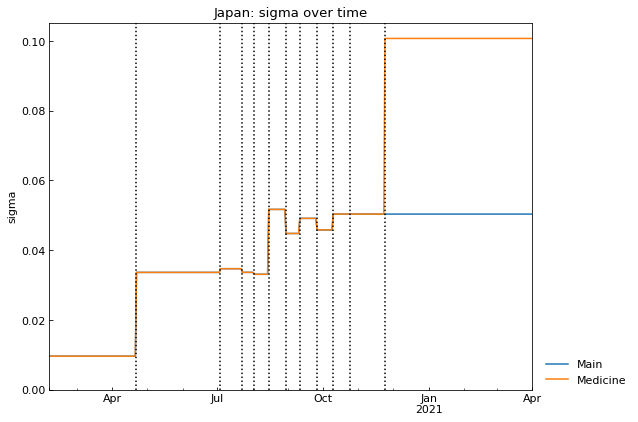

In [43]:
_ = snl.history(target="sigma")

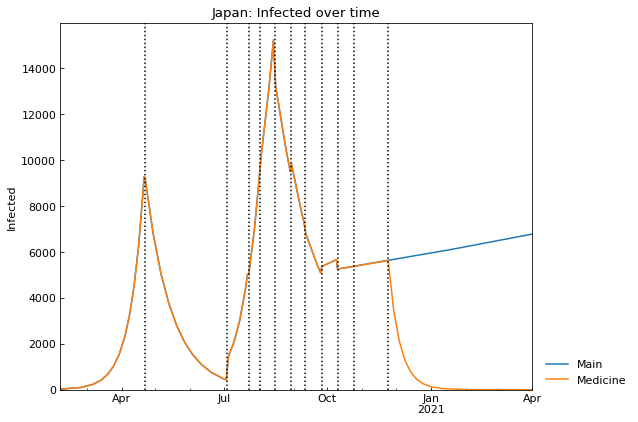

In [44]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

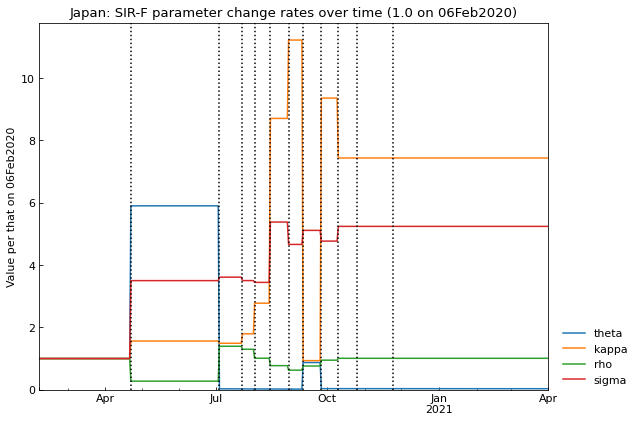

In [45]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [46]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	10th phase (10Oct2020 - 24Oct2020): finished 1668 trials in 1 min  0 sec


	 0th phase (06Feb2020 - 21Apr2020): finished 1664 trials in 1 min  0 sec

	 2nd phase (04Jul2020 - 22Jul2020): finished 1709 trials in 1 min  0 sec

	 1st phase (22Apr2020 - 03Jul2020): finished 1656 trials in 1 min  0 sec

	 3rd phase (23Jul2020 - 01Aug2020): finished 1710 trials in 1 min  0 sec

	 7th phase (01Sep2020 - 10Sep2020): finished  251 trials in 0 min  5 sec

	 6th phase (30Aug2020 - 31Aug2020): finished  340 trials in 0 min  5 sec

	 5th phase (15Aug2020 - 29Aug2020): finished  420 trials in 0 min 10 sec

	 8th phase (11Sep2020 - 25Sep2020): finished  197 trials in 0 min  5 sec

	 9th phase (26Sep2020 - 09Oct2020): finished  428 trials in 0 min 10 sec

	 4th phase (02Aug2020 - 14Aug2020): finished 1997 trials in 1 min  0 sec

Completed optimization. Total: 3 min  1 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 7th phase (01Sep2020 - 24Oct2020): finished 6433 trials in 1 min  0 sec

Completed optimization. Total: 1 min  0 sec


In [47]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  21Apr2020  SIR-F  5.20  0.018968  0.000063   
              1st    22Apr2020  03Jul2020  SIR-F  0.38  0.062348  0.000767   
              2nd    04Jul2020  22Jul2020  SIR-F  2.05  0.000541  0.000094   
              3rd    23Jul2020  01Aug2020  SIR-F  1.97  0.000589  0.000114   
              4th    02Aug2020  14Aug2020  SIR-F  1.56  0.000172  0.000176   
              5th    15Aug2020  29Aug2020  SIR-F  0.76  0.000468  0.000552   
              6th    30Aug2020  31Aug2020  SIR-F  0.92  0.000321  0.000770   
              7th    01Sep2020  10Sep2020  SIR-F  0.70  0.000349  0.000711   
              8th    11Sep2020  25Sep2020  SIR-F  0.76  0.000349  0.000709   
              9th    26Sep2020  09Oct2020  SIR-F  1.05  0.000647  0.000593   
              10th   10Oct2020  24Oct2020  SIR-F  1.02  0.000605  0.000471   
Retrospective 0th    06Feb2020  21Apr2020  SIR-F  5.20  0.018968  0.000063   
              1st    22Apr2020  03Jul2020  SIR-F  0.38  0.062348  0.000767   
              2nd    04Jul2020  22Jul2020  SIR-F  2.05  0.000541  0.000094   
              3rd    23Jul2020  01Aug2020  SIR-F  1.97  0.000589  0.000114   
              4th    02Aug2020  14Aug2020  SIR-F  1.56  0.000172  0.000176   
              5th    15Aug2020  29Aug2020  SIR-F  0.76  0.000468  0.000552   
              6th    30Aug2020  31Aug2020  SIR-F  0.92  0.000321  0.000770   
              7th    01Sep2020  24Oct2020  SIR-F  0.92  0.000321  0.000770   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.051253  0.009609  0.944454    1664  1 min  0 sec  
              1st    0.013918  0.033575  0.819038    1656  1 min  0 sec  
              2nd    0.071465  0.034698  0.038879    1709  1 min  0 sec  
              3rd    0.066524  0.033642  0.033520    1710  1 min  0 sec  
              4th    0.051761  0.033087  0.061574    1997  1 min  0 sec  
              5th    0.039566  0.051693  0.050953     420  0 min 10 sec  
              6th    0.030730  0.032604  0.000008     340  0 min  5 sec  
              7th    0.033876  0.047411  0.011812     251  0 min  5 sec  
              8th    0.037677  0.048935  0.086954     197  0 min  5 sec  
              9th    0.048559  0.045813  0.031941     428  0 min 10 sec  
              10th   0.051649  0.050354  0.024116    1668  1 min  0 sec  
Retrospective 0th    0.051253  0.009609  0.944454    1664  1 min  0 sec  
              1st    0.013918  0.033575  0.819038    1656  1 min  0 sec  
              2nd    0.071465  0.034698  0.038879    1709  1 min  0 sec  
              3rd    0.066524  0.033642  0.033520    1710  1 min  0 sec  
              4th    0.051761  0.033087  0.061574    1997  1 min  0 sec  
              5th    0.039566  0.051693  0.050953     420  0 min 10 sec  
              6th    0.030730  0.032604  0.000008     340  0 min  5 sec  
              7th    0.030730  0.032604  0.494377    6433  1 min  0 sec

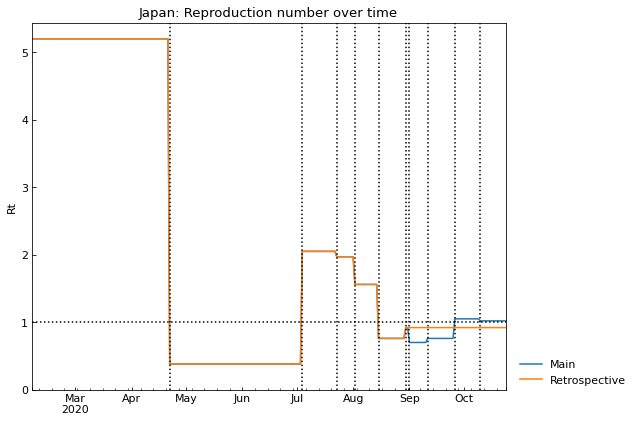

In [48]:
# History of reproduction number
_ = snl_retro.history("Rt")

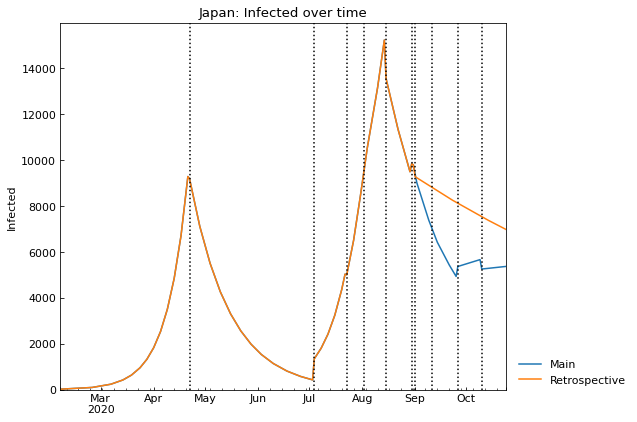

In [49]:
# History of Infected
_ = snl_retro.history("Infected")

In [50]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 25Oct2020,Infected on 25Oct2020,Fatal on 25Oct2020,7th_Rt,8th_Rt,9th_Rt,10th_Rt
Main,15223,14Aug2020,96459,5373,1704,0.70,0.76,1.05,1.02
Retrospective,15223,14Aug2020,95106,6947,1974,0.92,-,-,-
